In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [3]:
# import tensorflow as tf

# tf.compat.v1.enable_eager_execution()

In [4]:
import tensorflow as tf
import malaya_speech

In [5]:
from malaya_speech.train.model.vits import model
from malaya_speech.train.model import vits

In [6]:
hparams = vits.HParams(**malaya_speech.config.vits_base_config)
hparams

{'model': {'inter_channels': 192, 'hidden_channels': 192, 'filter_channels': 768, 'n_heads': 2, 'n_layers': 6, 'kernel_size': 3, 'p_dropout': 0.1, 'resblock': '1', 'resblock_kernel_sizes': [3, 7, 11], 'resblock_dilation_sizes': [[1, 3, 5], [1, 3, 5], [1, 3, 5]], 'upsample_rates': [8, 8, 2, 2], 'upsample_initial_channel': 512, 'upsample_kernel_sizes': [16, 16, 4, 4], 'n_layers_q': 3, 'use_spectral_norm': False}, 'train': {'log_interval': 200, 'eval_interval': 1000, 'seed': 1234, 'epochs': 20000, 'learning_rate': 0.0002, 'betas': [0.8, 0.99], 'eps': 1e-09, 'batch_size': 64, 'fp16_run': True, 'lr_decay': 0.999875, 'segment_size': 8192, 'init_lr_ratio': 1, 'warmup_epochs': 0, 'c_mel': 45, 'c_kl': 1.0}, 'data': {'max_wav_value': 32768.0, 'sampling_rate': 22050, 'filter_length': 1024, 'hop_length': 256, 'win_length': 1024, 'n_mel_channels': 80, 'mel_fmin': 0.0, 'mel_fmax': None, 'add_blank': True, 'n_speakers': 0}}

In [7]:
spec_channels = hparams.data.filter_length // 2 + 1
segment_size = hparams.train.segment_size // hparams.data.hop_length
spec_channels, segment_size

(513, 32)

In [8]:
import json
import os
from glob import glob

with open('../speech/imda/output.json') as fopen:
    data = json.load(fopen)
    
wavs = glob('../speech/imda/*.WAV')

In [9]:
vocab = malaya_speech.utils.text.TTS_SYMBOLS

batch = []
for w in wavs:
    t = data[os.path.split(w)[1]]
    y, _ = malaya_speech.load(w)
    batch.append((y, malaya_speech.utils.text.tts_encode(t, vocab)))

In [10]:
from librosa.filters import mel as librosa_mel_fn

MEL = None

def dynamic_range_compression(x, C=1, clip_val=1e-5):
    """
    PARAMS
    ------
    C: compression factor
    """
    return tf.log(tf.clip_by_value(x, clip_val, tf.reduce_max(x)) * C)


def dynamic_range_decompression(x, C=1):
    """
    PARAMS
    ------
    C: compression factor used to compress
    """
    return tf.exp(x) / C


def spectral_normalize(magnitudes):
    output = dynamic_range_compression(magnitudes)
    return output


def spectral_de_normalize_torch(magnitudes):
    output = dynamic_range_decompression(magnitudes)
    return output

def spectrogram_tf(audio_norm, filter_length, hop_length):
    spec = tf.abs(tf.signal.stft(
        audio_norm,
        filter_length,
        hop_length,
        fft_length=None,
        window_fn=tf.signal.hann_window,
        pad_end=False,
    ))
    spec = tf.sqrt(spec ** 2 + 1e-6)
    return spec

def spec_to_mel(spec, n_fft, num_mels, sampling_rate, fmin, fmax):
    global MEL
    if MEL is None:
        MEL = tf.convert_to_tensor(librosa_mel_fn(sampling_rate, n_fft, num_mels, fmin, fmax))
    
    spec = tf.matmul(spec, tf.transpose(MEL))
    spec = spectral_normalize(spec)
    return spec

In [11]:
X = tf.compat.v1.placeholder(tf.float32, [None, None], name = 'X_placeholder')
X_len = tf.compat.v1.placeholder(tf.int32, [None], name = 'X_len_placeholder')

In [12]:
batch_size = tf.shape(X)[0]
features = tf.TensorArray(dtype = tf.float32, size = batch_size, dynamic_size = True, infer_shape = False)
features_len = tf.TensorArray(dtype = tf.int32, size = batch_size)

init_state = (0, features, features_len)

def condition(i, features, features_len):
    return i < batch_size

def body(i, features, features_len):
    f = spectrogram_tf(X[i, :X_len[i]], hparams.data.filter_length, hparams.data.hop_length)
#     f = spec_to_mel(f, hparams.data.filter_length, hparams.data.n_mel_channels, hparams.data.sampling_rate,
#                   hparams.data.mel_fmin, hparams.data.mel_fmax)
    f_len = tf.shape(f)[0]
    return i + 1, features.write(i, f), features_len.write(i, f_len)

_, features, features_len = tf.while_loop(condition, body, init_state)
features_len = features_len.stack()
padded_features = tf.TensorArray(dtype = tf.float32, size = batch_size)
padded_lens = tf.TensorArray(dtype = tf.int32, size = batch_size)
maxlen = tf.reduce_max(features_len)

init_state = (0, padded_features, padded_lens)

def condition(i, padded_features, padded_lens):
    return i < batch_size

def body(i, padded_features, padded_lens):
    f = features.read(i)
    len_f = tf.shape(f)[0]
    f = tf.pad(f, [[0, maxlen - tf.shape(f)[0]], [0,0]])
    return i + 1, padded_features.write(i, f), padded_lens.write(i, len_f)

_, padded_features, padded_lens = tf.while_loop(condition, body, init_state)
padded_features = padded_features.stack()
padded_lens = padded_lens.stack()
padded_lens.set_shape((None,))
padded_features.set_shape((None, None, spec_channels))
padded_features, padded_lens

(<tf.Tensor 'TensorArrayStack_1/TensorArrayGatherV3:0' shape=(?, ?, 513) dtype=float32>,
 <tf.Tensor 'TensorArrayStack_2/TensorArrayGatherV3:0' shape=(?,) dtype=int32>)

In [13]:
batch_x, batch_y = [b[0] for b in batch[:2]], [b[1] for b in batch[:2]]
x, x_len = malaya_speech.utils.padding.sequence_1d(batch_x, return_len = True)

In [14]:
y, y_len = malaya_speech.utils.padding.sequence_1d(batch_y, return_len = True)

In [15]:
# sess = tf.Session()
# sess.run([padded_features, padded_lens], feed_dict = {X: x, X_len: x_len})

In [16]:
model = vits.Model(len(vocab), spec_channels, segment_size, **hparams.model)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [17]:
# x = tf.constant([[1,2,3,4,5], [2,3,0,0,0]])
# x_lengths = tf.constant([5, 2])
# y = tf.random.normal(shape = (2, 100, spec_channels))
# y_lengths = tf.constant([50, 100])

In [18]:
T = tf.placeholder(tf.int32, [None, None])
T_lengths = tf.placeholder(tf.int32, [None])

In [19]:
y_hat, l_length, attn, ids_slice, x_mask, z_mask,\
      (z, z_p, m_p, logs_p, m_q, logs_q) = model(T, T_lengths, padded_features, padded_lens)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [20]:
outputs = model.infer(T, T_lengths)
outputs

(<tf.Tensor 'generator/Tanh:0' shape=(?, ?, 1) dtype=float32>,
 <tf.Tensor 'transpose:0' shape=(?, ?, ?) dtype=float32>,
 <tf.Tensor 'ExpandDims:0' shape=(?, ?, 1) dtype=float32>,
 (<tf.Tensor 'residual_coupling_block/residual_coupling_layer/concat:0' shape=(?, ?, 192) dtype=float32>,
  <tf.Tensor 'add:0' shape=(?, ?, 192) dtype=float32>,
  <tf.Tensor 'MatMul:0' shape=(?, ?, 192) dtype=float32>,
  <tf.Tensor 'MatMul_1:0' shape=(?, ?, 192) dtype=float32>))

In [28]:
outputs[:2]

(<tf.Tensor 'generator/Tanh:0' shape=(?, ?, 1) dtype=float32>,
 <tf.Tensor 'transpose:0' shape=(?, ?, ?) dtype=float32>)

In [21]:
from malaya_speech.train.model.vits import commons

In [22]:
def kl_loss(z_p, logs_q, m_p, logs_p, z_mask):
    kl = logs_p - logs_q - 0.5
    kl += 0.5 * ((z_p - m_p)**2) * tf.exp(-2. * logs_p)
    kl = tf.reduce_sum(kl * z_mask)
    l = kl / tf.reduce_sum(z_mask)
    return l

loss_kl = kl_loss(z_p, logs_q, m_p, logs_p, z_mask) * hparams.train.c_kl

In [23]:
z_p.shape, m_p.shape

(TensorShape([Dimension(None), Dimension(None), Dimension(192)]),
 TensorShape([Dimension(None), Dimension(None), Dimension(192)]))

In [24]:
loss_dur = tf.reduce_sum(l_length)

In [25]:
loss_kl, loss_dur

(<tf.Tensor 'mul_21:0' shape=() dtype=float32>,
 <tf.Tensor 'Sum_4:0' shape=() dtype=float32>)

In [26]:
optimizer = malaya_speech.train.optimizer.adamw.create_optimizer(loss_kl + loss_dur, 1e-4, 10000, 1000)

In [27]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [30]:
o_ = sess.run(outputs[:2], feed_dict = {T: y, T_lengths: y_len})
o_[0].shape, o_[1].shape

In [31]:
o_[0].shape, o_[1].shape

((2, 15616, 1), (2, 61, 61))

In [33]:
for i in range(100):
    print(i, sess.run([loss_kl, loss_dur, optimizer], feed_dict = {X: x,
                                                        X_len: x_len,
                                                        T: y,
                                                        T_lengths: y_len}))

0 [51544.19, 9.168989, None]
1 [41915.035, 9.62646, None]
2 [36852.77, 9.57003, None]
3 [38734.258, 7.606784, None]
4 [29665.8, 8.324625, None]
5 [24615.021, 8.29758, None]
6 [18310.604, 9.107053, None]
7 [14995.623, 10.621237, None]
8 [11428.391, 9.412462, None]
9 [9430.883, 10.378833, None]
10 [7287.7007, 7.838971, None]
11 [5100.747, 10.144326, None]
12 [4324.5845, 9.158051, None]
13 [3318.5347, 8.06123, None]
14 [2644.5652, 7.010334, None]
15 [1980.0608, 7.7255516, None]
16 [1621.77, 6.74211, None]
17 [1371.23, 5.651843, None]
18 [1055.5049, 7.013368, None]
19 [909.50305, 5.644163, None]
20 [735.5644, 6.1008005, None]
21 [644.1857, 4.916815, None]
22 [560.1258, 5.2424135, None]
23 [493.04727, 5.932761, None]
24 [448.78198, 5.039339, None]
25 [389.4655, 4.6366715, None]
26 [354.9195, 5.818202, None]
27 [322.6205, 4.1776686, None]
28 [301.2597, 4.943224, None]
29 [278.6023, 4.06209, None]
30 [262.08142, 5.2701607, None]
31 [246.40277, 3.4813304, None]
32 [233.30838, 4.1537075, None]


In [34]:
o_ = sess.run(outputs[:2], feed_dict = {T: y, T_lengths: y_len})
o_[0].shape, o_[1].shape

((2, 32768, 1), (2, 128, 61))

In [35]:
import matplotlib.pyplot as plt

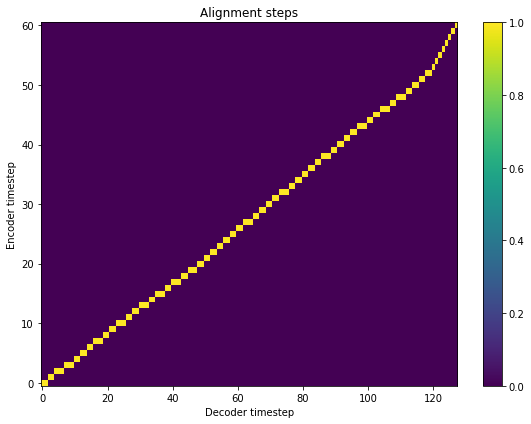

In [38]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    o_[1][1].T,
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()